In [9]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
import matplotlib.pyplot as plt
import numpy as np
import torch

In [10]:
model = HamiltonianMappingModel(input_dim=2, hidden_dim=128, num_layers=64)
model.flow

GsympNetFlow(
  (layers): ModuleList(
    (0-63): 64 x SymplecticCouplingLayer(
      (conditioner): GradientBasedConditioner()
    )
  )
)

In [22]:
n_actions = 1
n_angles = 1000
r_min = 0.5
r_max = 1.5
omega_guess = 1
training_data, aa_guess = generate_sho_orbits(n_actions, omega=omega_guess, t_end=10, n_steps=n_angles, r_bounds=[r_min,r_max]) #

Text(0.5, 1.0, 'Toy Orbits')

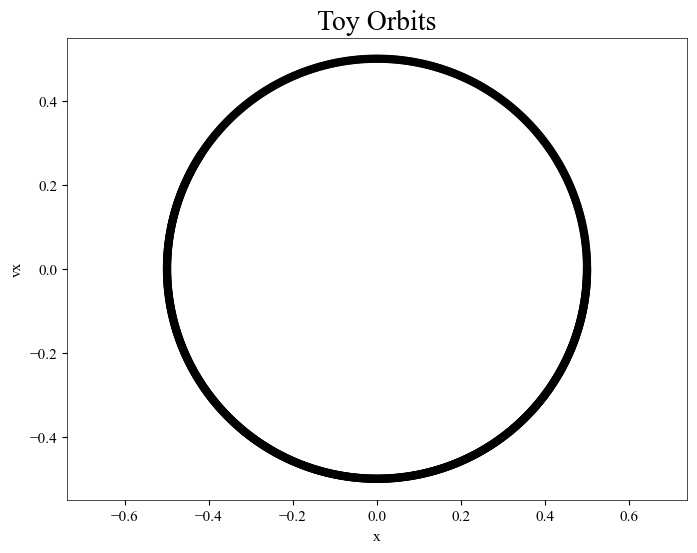

In [23]:
plt.scatter(*training_data.T)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('vx')
plt.title('Toy Orbits', fontsize=20)

100%|██████████| 1000/1000 [00:54<00:00, 18.28it/s]


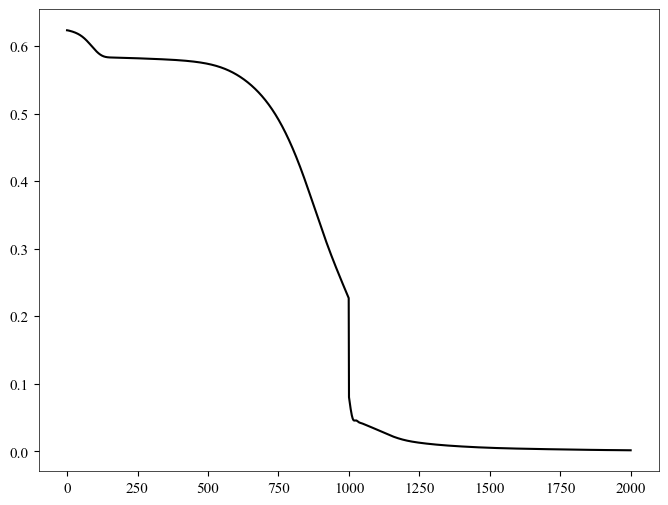

In [24]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

steps = 1000
model.train(isoDiskPotential, training_data, steps)
plt.plot(model.loss_list)

In [25]:
ps_nf = model.aa_to_ps(aa_guess)

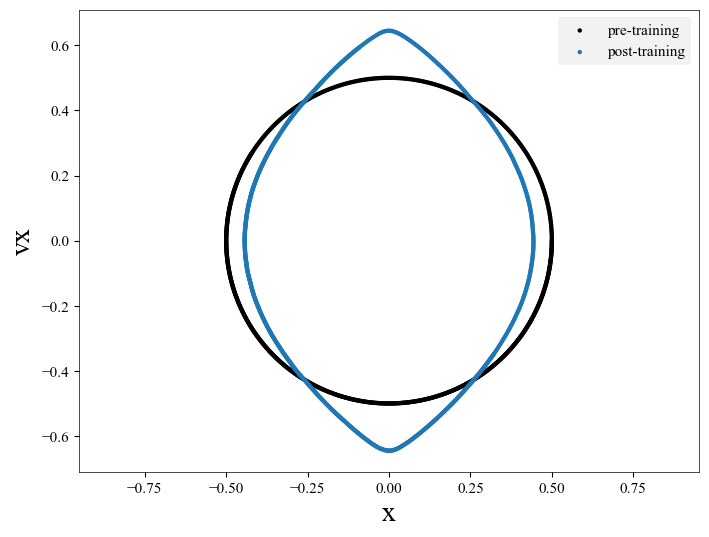

In [30]:
plt.scatter(*training_data.T.detach(), s=10, label='pre-training')
plt.scatter(*ps_nf.T.detach(), s=10, label='post-training')
plt.axis('equal')
plt.xlabel('x', fontsize=20)
plt.ylabel('vx', fontsize=20)
plt.legend()
plt.show()

In [27]:
from orbitflows import H

Text(0, 0.5, 'energy')

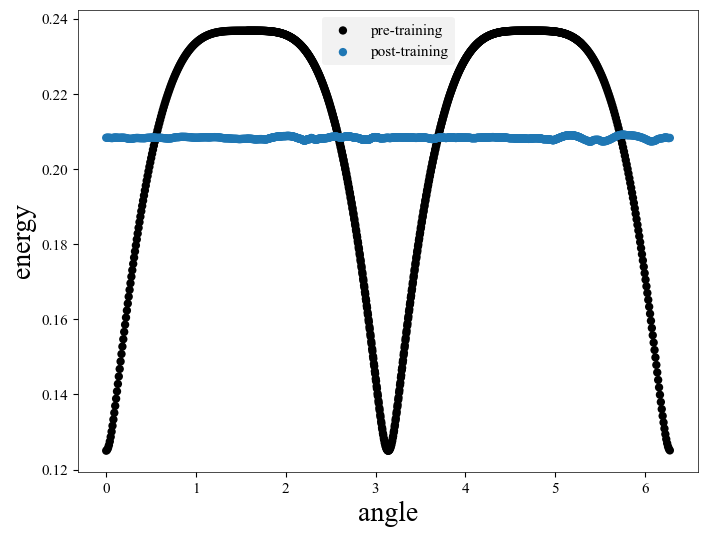

In [29]:
plt.scatter(aa_guess[...,0], H(training_data, model.targetPotential).detach(), label='pre-training')
plt.scatter(aa_guess[...,0], model.hamiltonian(aa_guess).detach(), label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=20)
plt.ylabel('energy', fontsize=20)

You can also continuously train, if you want to fine tune the results, for example.

100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


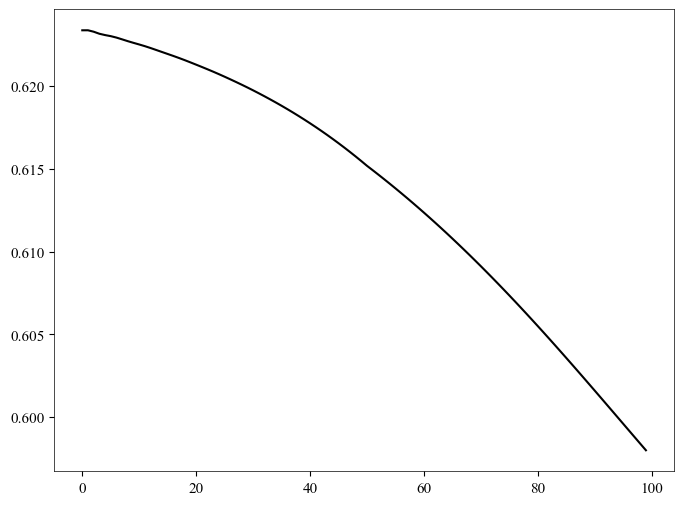

In [7]:
model.train(isoDiskPotential, training_data, steps)
plt.plot(model.loss_list)